# UCF50 Sports Dataset

**Subset: 5 Sports**

- Basketball
- PlayingPiano
- PullUps
- Skiing
- WalkingWithDog

## Dependecies

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import TimeDistributed, Input, LSTM, Dense, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Functions

### Extract Frames

In [ ]:
def extract_frames(video_path, frame_size=(112, 112), frame_num=16):
    try:
        video = cv2.VideoCapture(video_path)
        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames == 0:
            print(f"Error: No se encontraron frames en el video {video_path}")
            return None

        interval = total_frames // frame_num

        frames = []
        previous_frame = None

        for i in range(frame_num):
            frame_index = min(i * interval, total_frames - 1)
            video.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            ret, frame = video.read()

            if ret:
                frame_resized = cv2.resize(frame, frame_size)
                frame_normalized = frame_resized / 255.0
                frames.append(frame_normalized)
                previous_frame = frame_normalized
            else:
                print(f"Error al leer el frame {frame_index} del video {video_path}. Usando el frame anterior.")
                if previous_frame is not None:
                    frames.append(previous_frame)
                else:
                    print(f"Error: No se pudo usar un frame anterior para {video_path} en el índice {frame_index}. Video posiblemente corrupto.")
                    video.release()
                    return None

        video.release()

        if len(frames) < frame_num:
            print(f"Advertencia: El video {video_path} tiene menos frames de los esperados. Usando los frames disponibles.")

        return np.array(frames)

    except Exception as e:
        print(f"Error al procesar el video {video_path}: {e}")
        return None

### Build Dataset

In [3]:
def build_dataset(path, frame_size=(32, 32), frame_num=16):

    data = []
    labels = []
    categories = sorted(os.listdir(path))

    label_encoder = LabelEncoder()
    label_encoder.fit(categories)
    print("Categorías:", label_encoder.classes_)
    for category in categories:
        category_path = os.path.join(path, category)
        print(f"Procesando videos de la categoría {category}...")
        for video_name in os.listdir(category_path):
            if video_name.endswith(('.avi', '.mp4', '.mov')):
                video_path = os.path.join(category_path, video_name)
                frames = extract_frames(video_path, frame_size, frame_num)
                if frames is not None:
                    data.append(frames)
                    label_numeric = label_encoder.transform([category])[0]
                    labels.append(label_numeric)
                else:
                    print(f"Error: No se pudieron extraer frames del video {video_path}. Omitiendo.")

    return data, labels, label_encoder

### Build CNN Model

In [4]:
def build_cnn(frame_size):

    input_tensor = Input(shape=(None, frame_size[0], frame_size[1], 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(frame_size[0], frame_size[1], 3))
    base_model.trainable = False
    time_distributed_layer = TimeDistributed(base_model)(input_tensor)
    
    cnn_model = Model(inputs=input_tensor, outputs=time_distributed_layer)

    return cnn_model

### Build CNN LSTM Model

In [5]:
def build_cnn_lstm(frame_size, num_clases):

    cnn = build_cnn(frame_size)

    cnn_output_shape = cnn.output.shape
    reshape_dim = (cnn_output_shape[-2] * cnn_output_shape[-1])
    reshaped_output = Reshape((-1, reshape_dim))(cnn.output)
    lstm_layer = LSTM(64)(reshaped_output)
    dropout_layer = Dropout(0.5)(lstm_layer)
    output_layer = Dense(num_clases, activation='softmax')(dropout_layer)
    
    model = Model(inputs=cnn.input, outputs=output_layer)

    return model


### Train Model

In [6]:
def train_model(model, data, labels, frame_size, num_clases, epochs=10, batch_size=32):

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        data, labels, test_size=0.2, random_state=42
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42
    )

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )

    loss, precision = model.evaluate(X_test, y_test, verbose=0)
    print(f"Pérdida en el conjunto de prueba: {loss}")
    print(f"Precisión en el conjunto de prueba: {precision}")
    
    model.save("model.keras")
    print("Modelo guardado.")

    return history

### Inference

In [ ]:
def inference(model, video_path, label_encoder, frame_size=(32, 32), num_frames=16):

    try:
        frames = extract_frames(video_path, frame_size, num_frames)

        if frames is None:
            print(f"Error: No se pudieron extraer frames del video {video_path}")
            return None

        frames = np.expand_dims(frames, axis=0)

        probabilities = model.predict(frames)
        predicted_class_index = np.argmax(probabilities)
        predicted_class = label_encoder.inverse_transform([predicted_class_index])[0]

        return predicted_class

    except Exception as e:
        print(f"Error durante la inferencia: {e}")
        return None


### Sample Predictions

In [55]:
def sample_predictions(model, path, label_encoder, frame_size=(32, 32), num_frames=16):

    categories = sorted(os.listdir(path))

    for category in categories:
        category_path = os.path.join(path, category)
        videos = sorted(os.listdir(category_path))

        if videos:
            first_video = videos[0]
            video_path = os.path.join(category_path, first_video)

            prediction = inference(model, video_path, label_encoder, frame_size, num_frames) # Use inference function

            if prediction:
                print(f"Categoría: {category}")
                print(f"Video: {first_video}")
                print(f"Clase predicha: {prediction}")

                try:  # Try to display a frame
                    video_capture = cv2.VideoCapture(video_path)
                    ret, frame = video_capture.read()
                    video_capture.release()

                    if ret:
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        plt.imshow(frame)
                        plt.title(f"Video: {first_video}")
                        plt.axis('off')
                        plt.show()
                    else:
                        print("No se pudo leer el primer frame del video para mostrar.")
                except Exception as e:
                    print(f"Error displaying frame: {e}")

            else:
                print(f"Error: No se pudieron extraer frames o realizar la inferencia para {video_path}")
        else:
            print(f"No se encontraron videos en la categoría: {category}")


## Testing

### Extract Frames

In [8]:
video_path = "data5/Basketball/v_Basketball_g01_c01.avi"
frames_processed = extract_frames(video_path)

if frames_processed is not None:
    print("Frames extraídos y procesados correctamente.")
    print("Shape del array de frames:", frames_processed.shape)

else:
    print("Error al samplear los frames del vídeo.")

Frames extraídos y procesados correctamente.
Shape del array de frames: (16, 112, 112, 3)


### Build CNN Model

In [9]:
frame_size = (112, 112)
cnn = build_cnn(frame_size)

cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, 112, 112, │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 4, 4,     │    23,587,712 │
│ (TimeDistributed)               │ 2048)                  │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

### Build CNN LSTM Model

In [10]:
frame_size = (32, 32)
num_clases = 5
cnn_lstm_model = build_cnn_lstm(frame_size, num_clases)

cnn_lstm_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None, 32, 32,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 1, 1,     │    23,587,712 │
│ (TimeDistributed)               │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, None, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,128,965 (92.04 MB)

 Trainable params: 541,253 (2.06 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Execution

In [ ]:
data_path = "data5"
data, labels, label_encoder = build_dataset(data_path)

Categorías: ['Basketball' 'PlayingPiano' 'PullUps' 'Skiing' 'WalkingWithDog']
Procesando videos de la categoría Basketball...
Procesando videos de la categoría PlayingPiano...
Procesando videos de la categoría PullUps...
Procesando videos de la categoría Skiing...
Procesando videos de la categoría WalkingWithDog...


In [12]:
data = np.array(data)
labels = to_categorical(labels)

print("Shape de los datos:", data.shape)
print("Shape de las etiquetas:", labels.shape)

Shape de los datos: (629, 16, 32, 32, 3)
Shape de las etiquetas: (629, 5)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 729ms/step - accuracy: 0.1756 - loss: 1.7699 - val_accuracy: 0.2302 - val_loss: 1.5958
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 290ms/step - accuracy: 0.1932 - loss: 1.6759 - val_accuracy: 0.2619 - val_loss: 1.5964
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 374ms/step - accuracy: 0.2249 - loss: 1.6084 - val_accuracy: 0.2063 - val_loss: 1.5984
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 357ms/step - accuracy: 0.2051 - loss: 1.6129 - val_accuracy: 0.2698 - val_loss: 1.5906
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 406ms/step - accuracy: 0.1941 - loss: 1.6109 - val_accuracy: 0.2619 - val_loss: 1.5931
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - accuracy: 0.2692 - loss: 1.5864 - val_accuracy: 0.2540 - val_loss: 1.5859
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 473ms/step - accuracy: 0.2842 - loss: 1.5837 - val_accuracy: 0.2619 - val_loss: 1.5850
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 382ms/step - accuracy: 0.2580 - loss: 1.5798 - val_

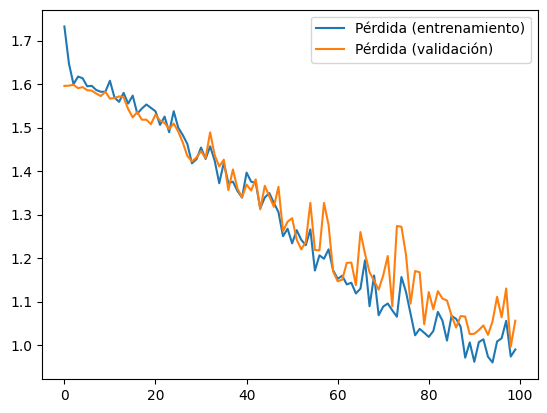

In [13]:
training_history = train_model(
    cnn_lstm_model, data, labels, frame_size, num_clases, epochs=100, batch_size=16
)

plt.plot(training_history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(training_history.history['val_loss'], label='Pérdida (validación)')
plt.legend()
plt.show()

## Sample Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Categoría: Basketball
Video: v_Basketball_g01_c01.avi
Clase predicha: Basketball


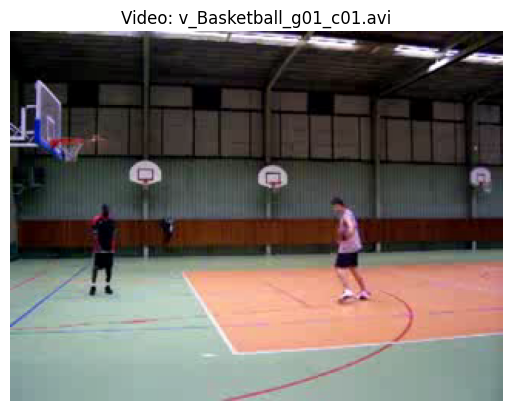

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Categoría: PlayingPiano
Video: v_PlayingPiano_g01_c01.avi
Clase predicha: Basketball


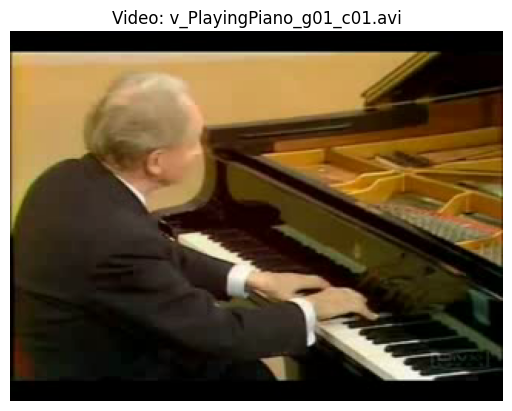

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Categoría: PullUps
Video: v_Pullup_g01_c01.avi
Clase predicha: PullUps


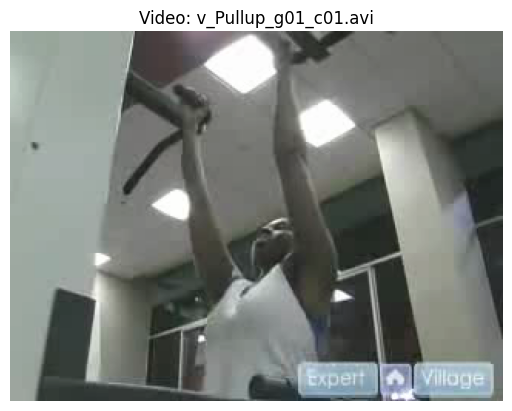

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Categoría: Skiing
Video: v_Skiing_g01_c01.avi
Clase predicha: Skiing


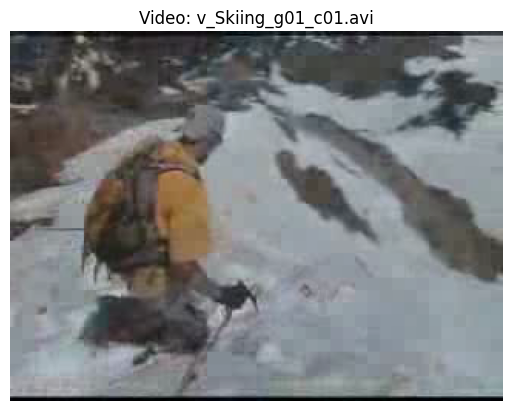

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Categoría: WalkingWithDog
Video: v_WalkingWithDog_g01_c01.avi
Clase predicha: Basketball


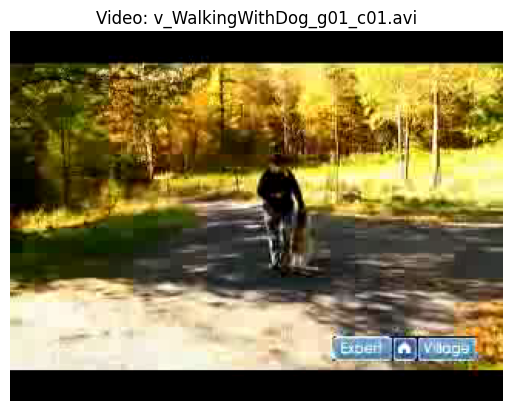

In [56]:
path = "data5"
loaded_model = tf.keras.models.load_model("model.keras")
sample_predictions(loaded_model, path, label_encoder)

## YouTube Videos

Error al leer el frame 405 del video videos/Basketball/basketball01.mov. Usando el frame anterior.
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Categoría: Basketball
Video: basketball01.mov
Clase predicha: Basketball


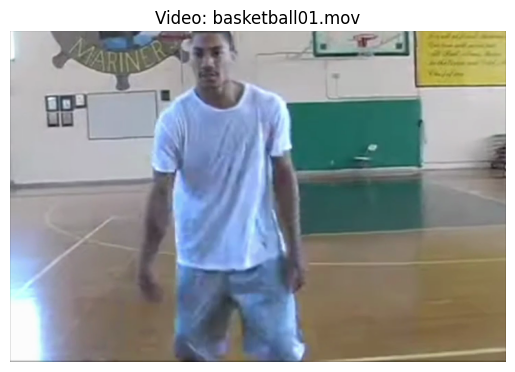

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Categoría: PlayingPiano
Video: piano01.mov
Clase predicha: PullUps


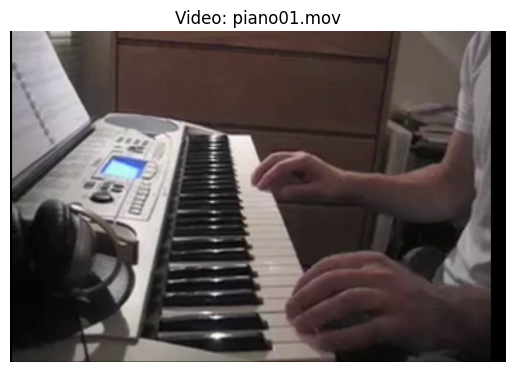

Error al leer el frame 360 del video videos/PullUps/pullups01.mov. Usando el frame anterior.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Categoría: PullUps
Video: pullups01.mov
Clase predicha: PullUps


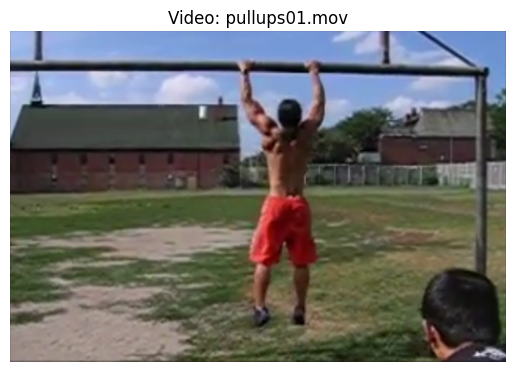

Error al leer el frame 375 del video videos/Skiing/skiing01.mov. Usando el frame anterior.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Categoría: Skiing
Video: skiing01.mov
Clase predicha: Skiing


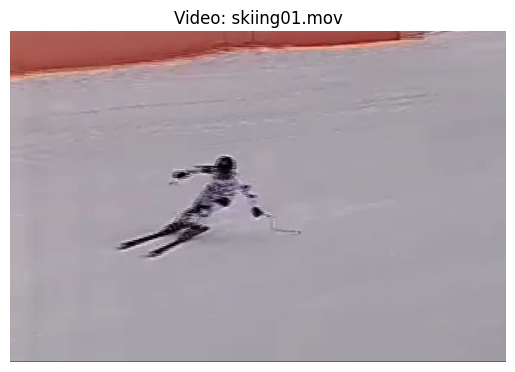

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Categoría: WalkingWithDog
Video: dogwalk01.mov
Clase predicha: Skiing


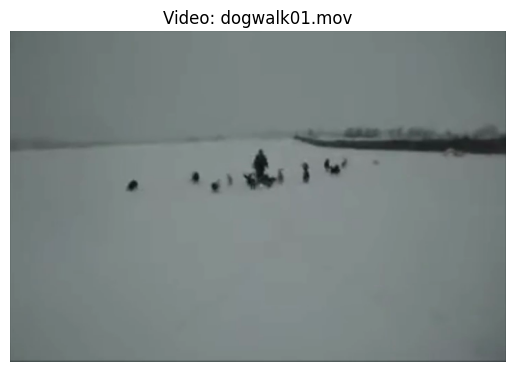

In [57]:
path = "videos"
loaded_model = tf.keras.models.load_model("model.keras")
sample_predictions(loaded_model, path, label_encoder)